<a href="https://colab.research.google.com/github/OrionXV/WeirdProject/blob/Ishaan/plotfitterClassDocumentedISHAANFIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
#Dependencies
import astropy.convolution.convolve as conv
from astropy.convolution import Box1DKernel as box1d
from astropy.convolution import Gaussian1DKernel as g1d
from astropy.table import Table
import pandas as pd
from matplotlib.pyplot import figure
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import math 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.optimize import leastsq
from scipy.special import erf
%config InLineBackend.figure_format = 'retina'

class Curve_Fitter():
    #data_path to initialize the dataframe which we will work on. Only required parameter.
    def __init__(self, data_path, convo_size = 60):
        self.data_raw = Table.read(data_path).to_pandas()
        self.data = self.convolve(self.data_raw, convo_size)#we will use convolved data for most of our purposes
        self.peak_list,_=find_peaks(self.data['RATE'], height= 50,prominence=17)  
        self.width=peak_widths(self.data['RATE'],self.peak_list,rel_height=0.75)
        self.start=self.width[2].astype(int)
        self.stop=self.width[3].astype(int)
        self.bdraw,self.bdata=self.bgdata()
        self.std=self.datastd()
        self.newcurve=self.peak_fitter()
        
        
        
                  

    #function to convovle the data, returns a new dataframe
    def convolve(self, data, width):
        data2 = data.copy()
        data2['RATE'] = conv(np.array(data['RATE']), kernel = g1d(width), boundary = 'extend')
        return data2
    
    #MATHS AHEAD
    #Z = (2*B + (C**2)*D)/(2*C)
    #Just a temp function so we don't have to write the expression again and again
    def z_func(self, B, C, D):
        return (2*B + (C**2)*D)/(2*C)
    
    #Our objective function, we will fit our curve over this
    def objective_func(self, T, A, B, C, D, E, F):
        return math.sqrt(np.pi*0.5)*A*C*np.exp(D/2*((2*B)+(C**2)*(D/2)-(2*(T*E+ F))))*(erf(self.z_func(B, C, D))- erf(self.z_func(B, C, D) - (T*E+ F)/C))

    #Defining the cost function. We will use sqrt(chi) for our calculations   
    def objective_cost_func(self, params, x, y):
        a0, b0, c0, d0, e0, f0 = params[0], params[1], params[2], params[3], params[4], params[5]
        return np.sqrt(((y - self.objective_func(x, a0, b0, c0, d0, e0, f0))**2)/y)

    #Sclaing functions
    def min_max_scaler(self, df):
        df['RATESCALED'] = (df['RATE']- df['RATE'].min())/(df['RATE'].max()- df['RATE'].min())
        df['TIMESCALED'] = (df['TIME']- df['TIME'].min())/(df['TIME'].max()- df['TIME'].min())*2

    def rev_scaler(self, df, x):
        return x*(df['RATE'].max()- df['RATE'].min()) + df['RATE'].min()
    
   
    def bgdata(self):
        c=self.data.copy()
        remove=[]
        for i in range(len(self.start)):
          remove+=np.arange(self.start[i],self.stop[i],1).tolist()
        remove=list(set(remove))
        rawbg=self.data_raw.drop(remove)
        return rawbg,np.mean(c.drop(remove)['RATE'])
    
    def datastd(self):
        zerodata=self.bdraw['RATE']-self.bdata
        return np.std(zerodata)
  

    def peak_fitter(self):
        self.min_max_scaler(self.data)
        peak_data_list = []
        peak_df_list = []
        input=[]
        scaledcurve=[]
        newcurve=[]
        
        for i in range(len(self.peak_list)):

            TIME = self.data['TIME'][self.start[i]:self.stop[i]] - self.data['TIME'][self.start[i]] #Some scaling
            RATE = self.data['RATESCALED'][self.start[i]:self.stop[i]]

            params = [0.2, 0.3, 0.3, 0.4, 0.1, 0.1] #Rando params 

            resultsq = leastsq(self.objective_cost_func, params, (TIME, RATE))
            a, b, c, d, e, f = resultsq[0][0], resultsq[0][1], resultsq[0][2], resultsq[0][3], resultsq[0][4], resultsq[0][5]
            input_time=np.arange(-2000,list(TIME)[-1]+8000,1)
            new_curve=self.objective_func(input_time, a, b, c, d, e, f)
            input=(self.data['TIME'][self.start[i]]+input_time)
            scaledcurve=(self.rev_scaler(self.data, new_curve))
            newcurve.append(pd.DataFrame({'TIME':input,'RATE':scaledcurve}))
        return newcurve

  
    def startidx(self):
      start=[]
      end=[]
      dellist=[]
      for i in range(len(self.peak_list)):
        c=self.newcurve[i][self.newcurve[i]['RATE']>=self.bdata+self.std].index.tolist()
        if len(c)<2:
           dellist.append(i)
           continue
        else:
           sloc=self.newcurve[i][self.newcurve[i]['RATE']>=self.bdata+self.std].index.tolist()[0]
           start.append(self.newcurve[i]['TIME'][sloc])
           eloc=self.newcurve[i][self.newcurve[i]['RATE']>=self.bdata+self.std].index.tolist()[-1]
           end.append(self.newcurve[i]['TIME'][eloc])
      print(dellist)
      if len(dellist)==0:
        pass
      else:
        self.peak_list=np.delete(self.peak_list,dellist)
        self.newcurve=np.delete(self.newcurve,dellist)
      return start,end


    def params(self):
      start,end=self.startidx()

      df=pd.DataFrame(columns=['decay_time','rise_time','peak_flux'])
      for i in range(len(self.peak_list)):
        df=df.append({'decay_time':end[i]-self.data['TIME'][self.peak_list[i]],
                   'rise_time':self.data['TIME'][self.peak_list[i]]-start[i],
                    'peak_flux':self.data['RATE'][self.peak_list[i]],
                     'peak_time':self.data['TIME'][self.peak_list[i]],
                     'start_time':start[i],
                     'end_time':end[i],
                     'background_flux':self.bdata},ignore_index=True)
      return df
    def plotter(self,std=False,newplot=False):
      plt.figure(figsize=(20,8))
      plt.plot(self.data['TIME'],self.data['RATE'])
      if std:
         plt.axhline(self.bdata+self.std,color='g')
      for i in range(len(self.peak_list)):
          plt.axvline(self.data['TIME'][self.peak_list[i]])
          if newplot:
            
            plt.plot(self.newcurve[i]['TIME'],self.newcurve[i]['RATE'])
      plt.show()
   




    #Plots our data, if you have already called fitter, then pass the params in here. 
    
            

In [140]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS" -O lc.zip && rm -rf /tmp/cookies.txt

--2022-03-16 11:27:21--  https://docs.google.com/uc?export=download&confirm=t&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS
Resolving docs.google.com (docs.google.com)... 108.177.127.101, 108.177.127.139, 108.177.127.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/io80bqnvbkpkmtg8l26m7tqj9obf4rio/1647429975000/04989237414475792611/*/1bRy8RDtWz5hbOn888XHSO3QToUAYCctS?e=download [following]
--2022-03-16 11:27:21--  https://doc-14-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/io80bqnvbkpkmtg8l26m7tqj9obf4rio/1647429975000/04989237414475792611/*/1bRy8RDtWz5hbOn888XHSO3QToUAYCctS?e=download
Resolving doc-14-a0-docs.googleusercontent.com (doc-14-a0-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-14-a0-docs.googleusercontent.com (doc-

In [ ]:
!unzip -q lc.zip

replace lc/ch2_xsm_20190914_v1_level2.lc? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import os
import copy
x = []
for a,b,c in os.walk('.'):
  x = c

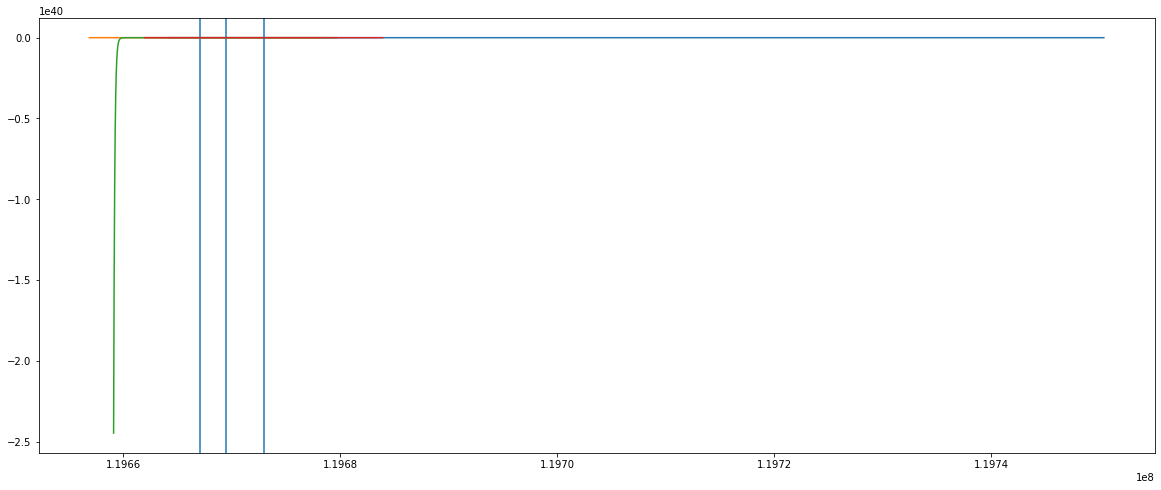

In [25]:
file.plotter(newplot=True)

In [26]:
len(file.peak_list)

3

In [ ]:
a=[]

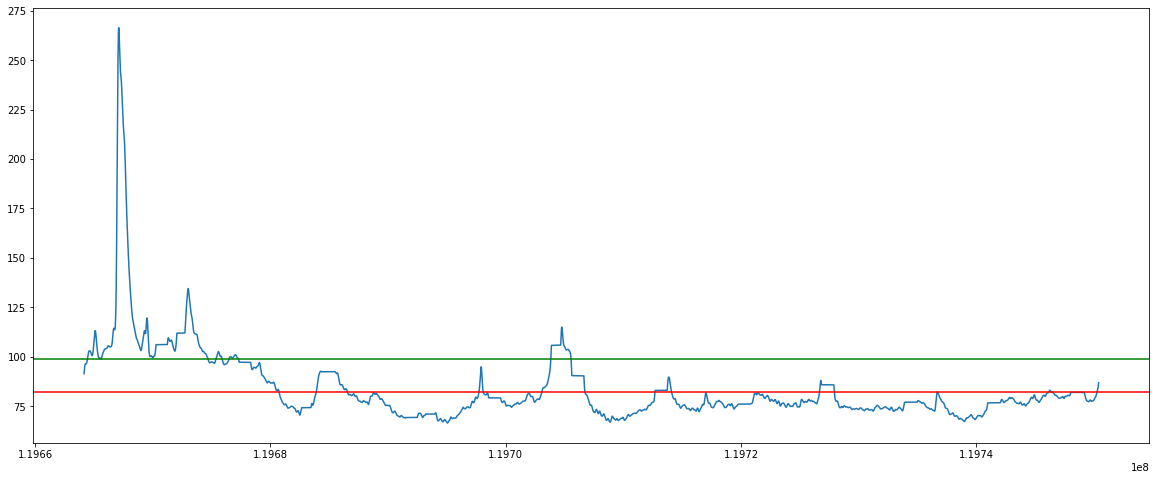

In [27]:
plt.figure(figsize=(20,8))
plt.plot(file.data['TIME'],file.data['RATE'])

plt.axhline(file.bdata,color='r')
plt.axhline(file.bdata+file.std,color='g')
#lt.plot(file.input[1],file.scaledcurve[1],color='red')
#lt.plot(file.input[2],file.scaledcurve[2],color='cyan')



In [172]:
file3=Curve_Fitter(c[20])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [173]:
file3.params()

[]


,decay_time,rise_time,peak_flux,background_flux,end_time,peak_time,start_time
0,1643.0,399.0,99.181938,18.175011,8.674922e+07,8.674758e+07,8.674718e+07
1,1076.0,701.0,52.538391,18.175011,8.680023e+07,8.679915e+07,8.679845e+07


In [168]:
data_raw = Table.read('/content/ch2_xsm_20210411_v1_level2.lc').to_pandas()

FileNotFoundError: ignored

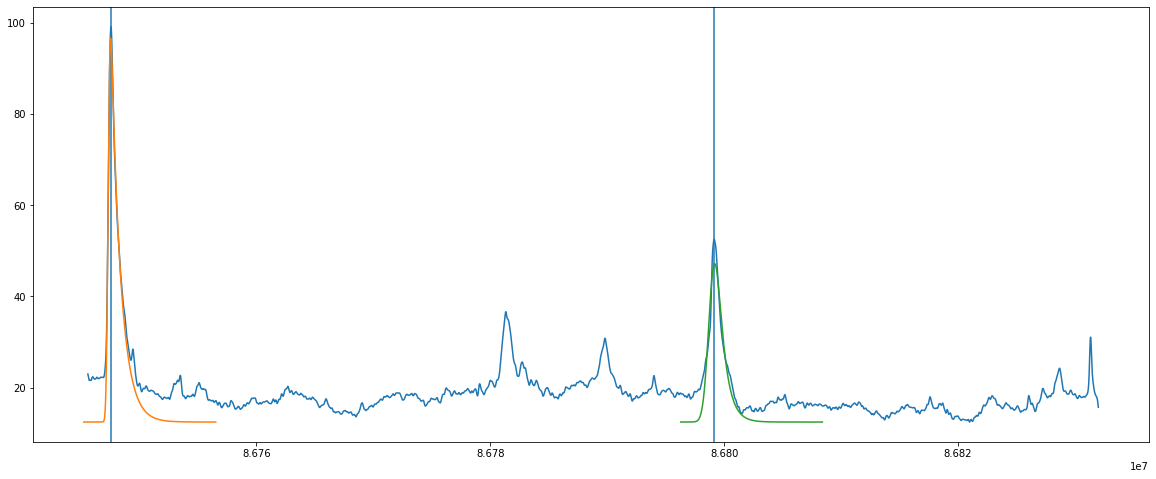

In [174]:
file3.plotter(newplot = True)

CURRENT NO. 0


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20210411_v1_level2.lc


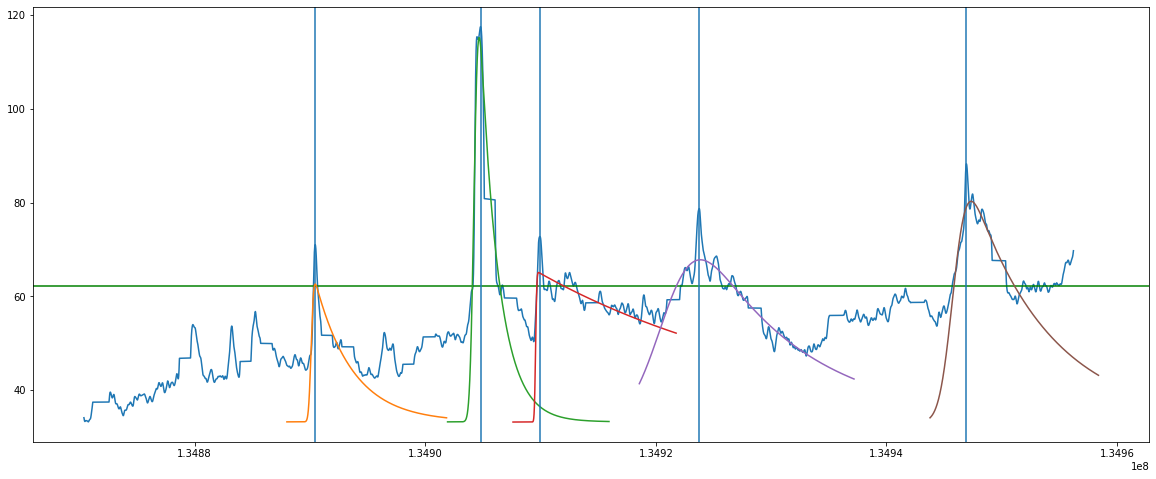

CURRENT NO. 1
[]
CURRENT NO. 2
[]
CURRENT NO. 3
[]
CURRENT NO. 4
[]
CURRENT NO. 5
[]
CURRENT NO. 6
[]
CURRENT NO. 7
[]
CURRENT NO. 8
[]
CURRENT NO. 9
[]
CURRENT NO. 10
[]
CURRENT NO. 11
[]
CURRENT NO. 12
[]
CURRENT NO. 13
[]
CURRENT NO. 14
[]
CURRENT NO. 15
[]
CURRENT NO. 16
[]
CURRENT NO. 17
[]
CURRENT NO. 18


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20190930_v1_level2.lc


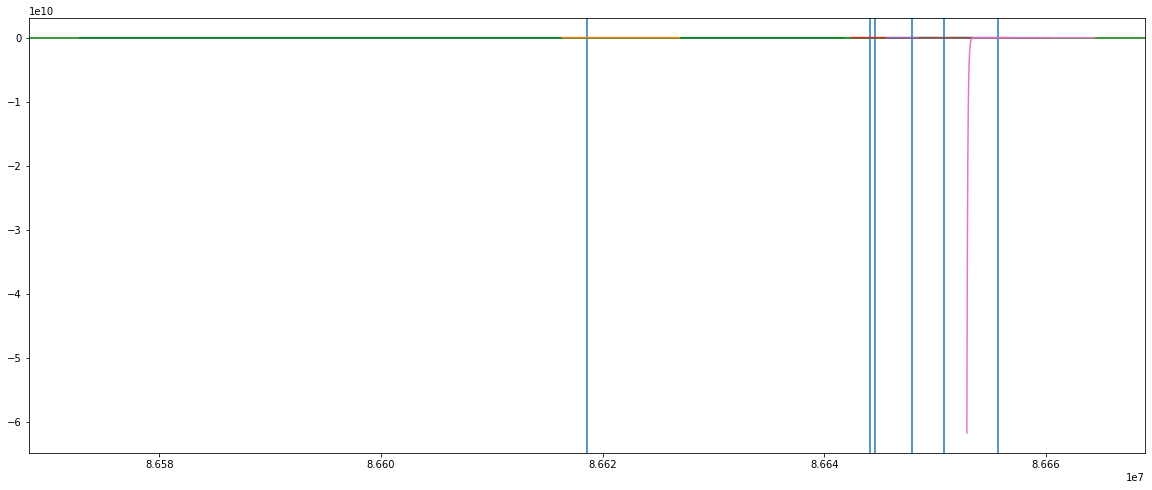

CURRENT NO. 19


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191001_v1_level2.lc


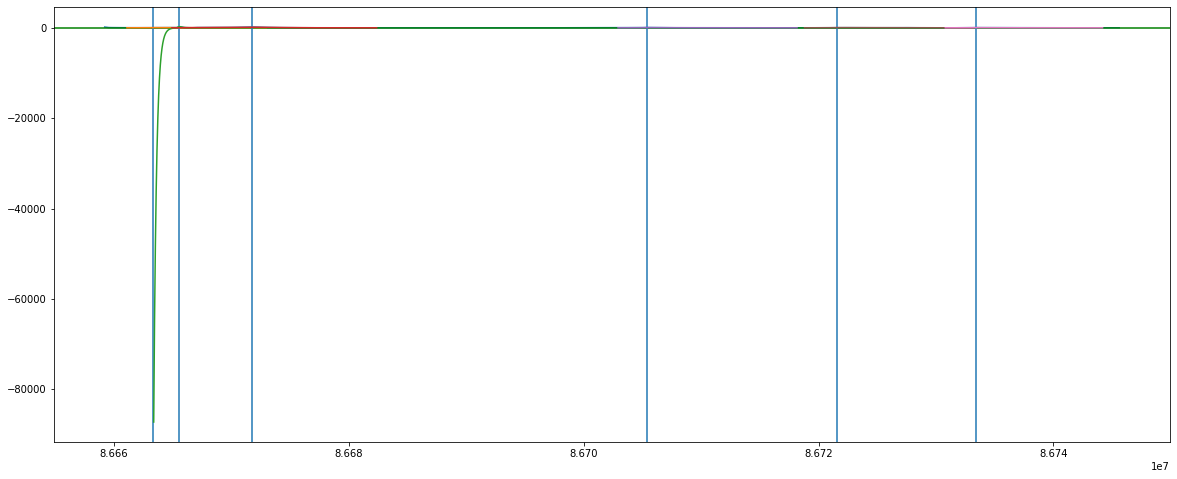

CURRENT NO. 20


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191002_v1_level2.lc


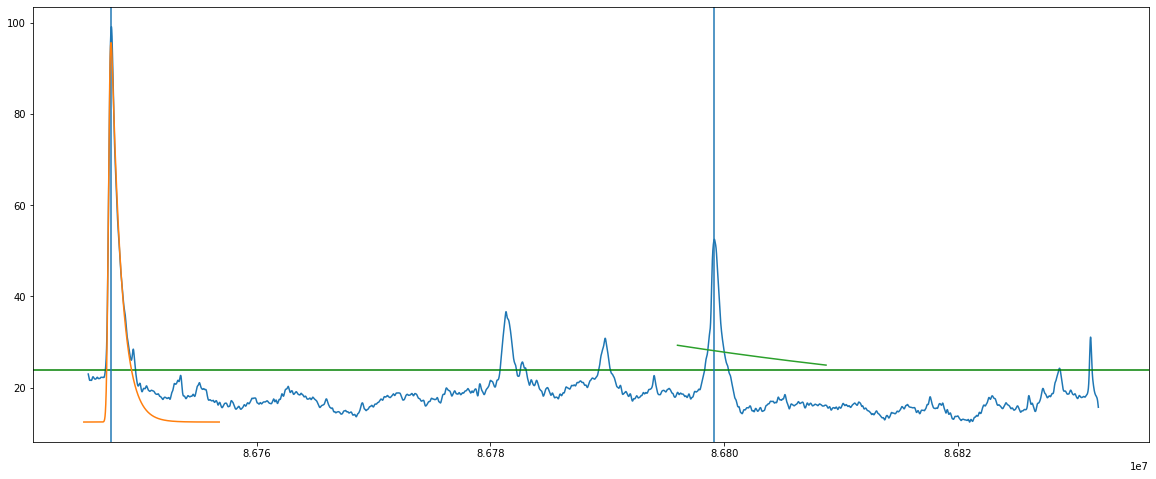

CURRENT NO. 21
[]
CURRENT NO. 22


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191004_v1_level2.lc


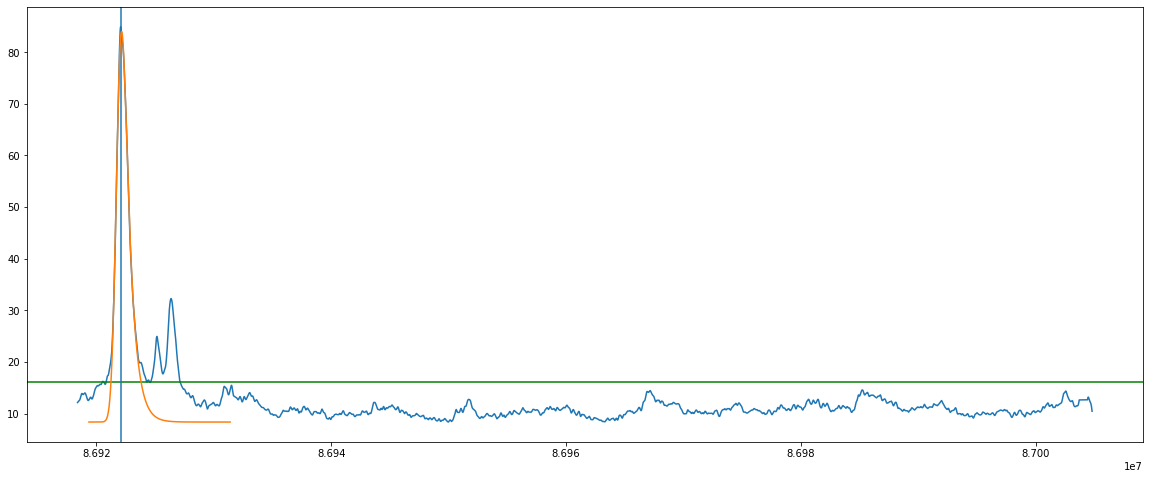

CURRENT NO. 23
[]
CURRENT NO. 24
[]
CURRENT NO. 25
[]
CURRENT NO. 26
[]
CURRENT NO. 27
[]
CURRENT NO. 28
[]
CURRENT NO. 29
[]
CURRENT NO. 30
[]
CURRENT NO. 31
[]
CURRENT NO. 32
[]
CURRENT NO. 33
[]
CURRENT NO. 34
[]
CURRENT NO. 35
[]
CURRENT NO. 36
[]
CURRENT NO. 37
[]
CURRENT NO. 38
[]
CURRENT NO. 39
[]
CURRENT NO. 40
[]
CURRENT NO. 41
[]
CURRENT NO. 42
[]
CURRENT NO. 43
[]
CURRENT NO. 44
[]
CURRENT NO. 45
[]
CURRENT NO. 46
[]
CURRENT NO. 47
[]
CURRENT NO. 48
[]
CURRENT NO. 49
[]
CURRENT NO. 50
[]
CURRENT NO. 51
[]
CURRENT NO. 52
[]
CURRENT NO. 53


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191105_v1_level2.lc


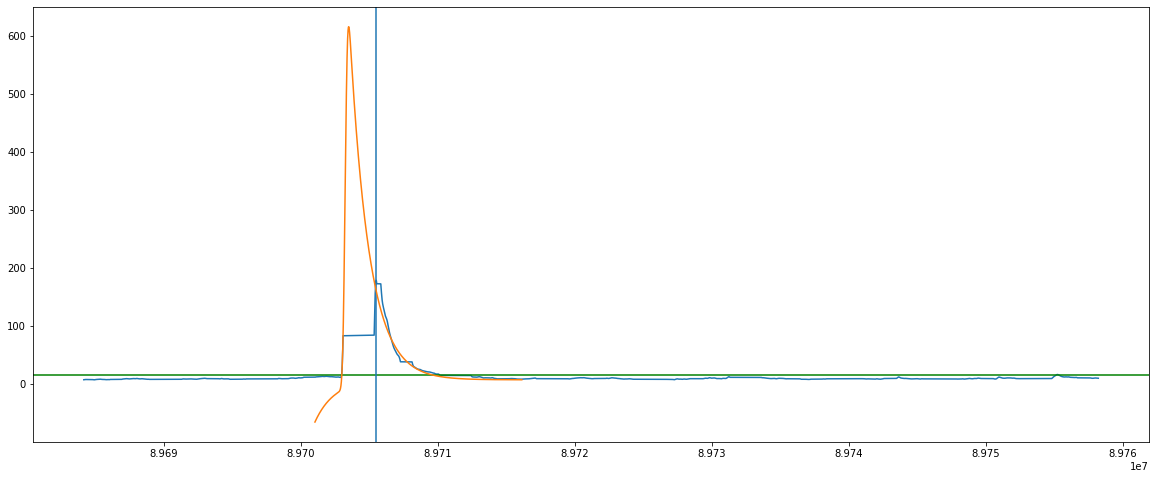

CURRENT NO. 54
[]
CURRENT NO. 55
[]
CURRENT NO. 56
[]
CURRENT NO. 57
[]
CURRENT NO. 58
[]
CURRENT NO. 59
[]
CURRENT NO. 60


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191112_v1_level2.lc


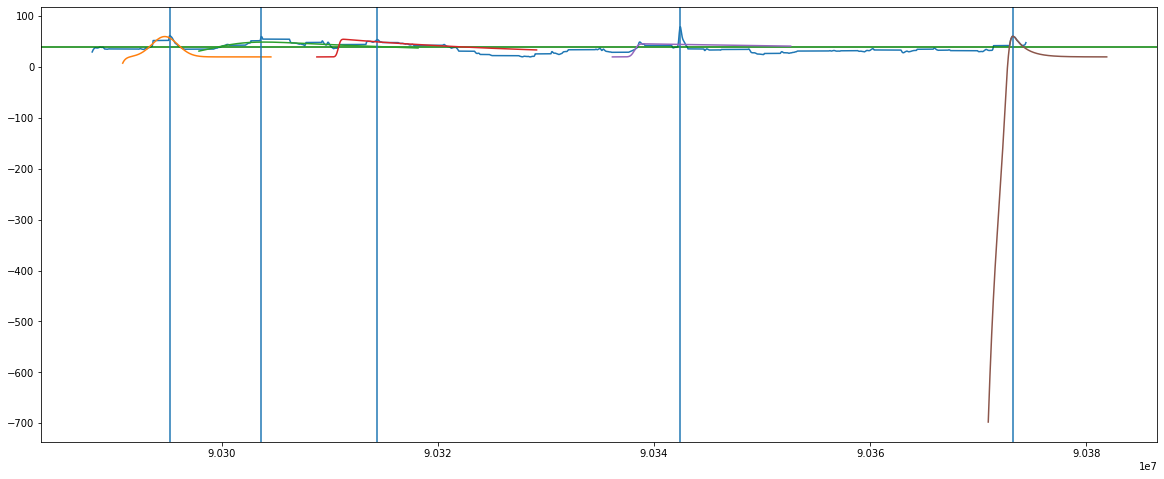

CURRENT NO. 61


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191113_v1_level2.lc


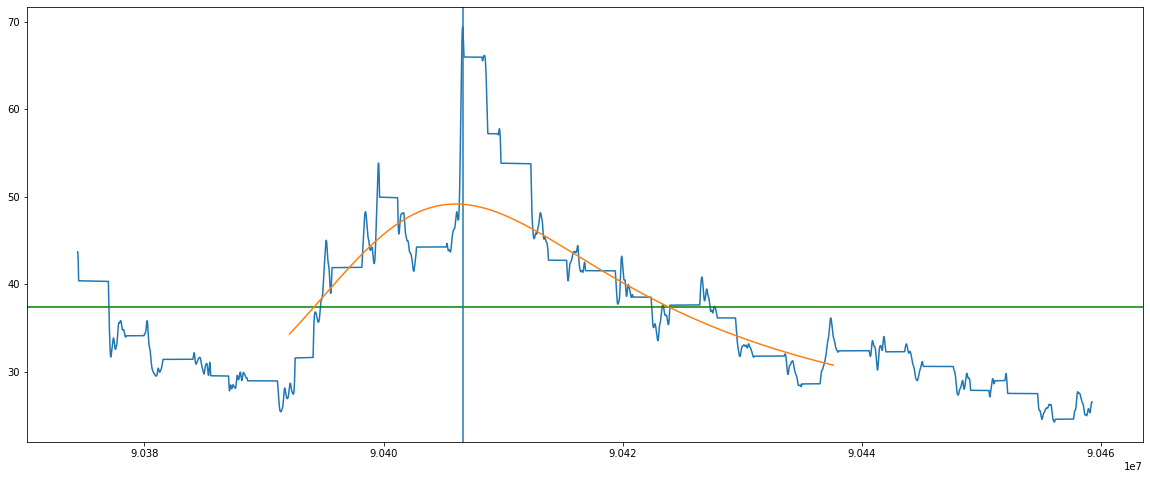

CURRENT NO. 62
[]
CURRENT NO. 63
[]
CURRENT NO. 64
[]
CURRENT NO. 65
[]
CURRENT NO. 66


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191118_v1_level2.lc


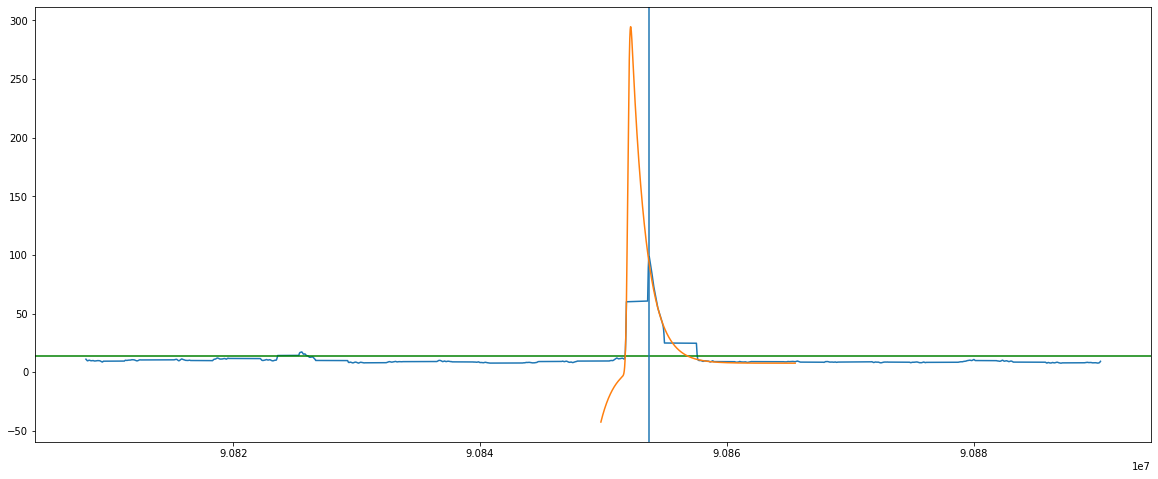

CURRENT NO. 67
[]
CURRENT NO. 68
[]
CURRENT NO. 69
[]
CURRENT NO. 70
[]
CURRENT NO. 71
[]
CURRENT NO. 72
[]
CURRENT NO. 73
[]
CURRENT NO. 74
[]
CURRENT NO. 75
[]
CURRENT NO. 76
[]
CURRENT NO. 77
[]
CURRENT NO. 78
[]
CURRENT NO. 79
[]
CURRENT NO. 80
[]
CURRENT NO. 81
[]
CURRENT NO. 82


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191223_v1_level2.lc


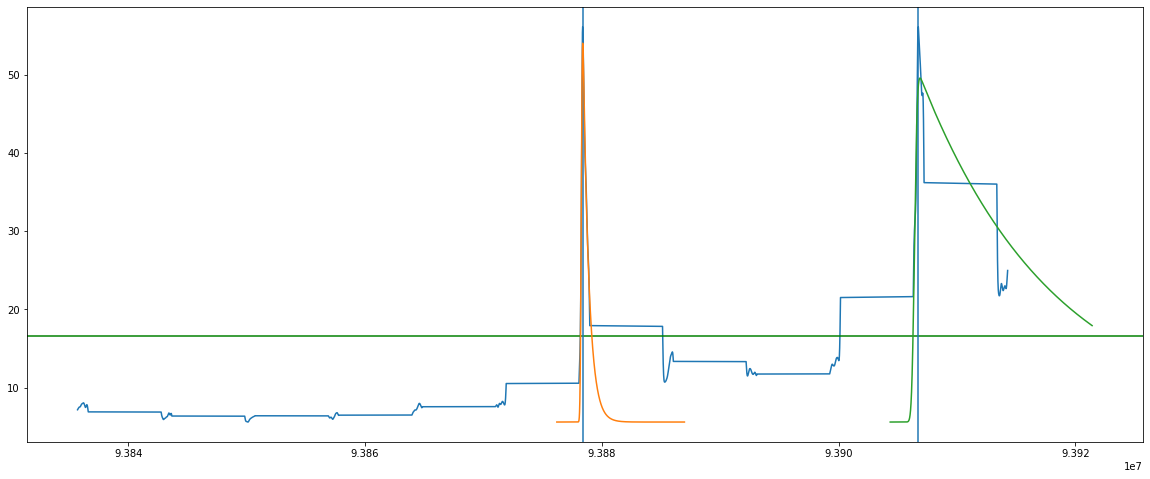

CURRENT NO. 83


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20191224_v1_level2.lc


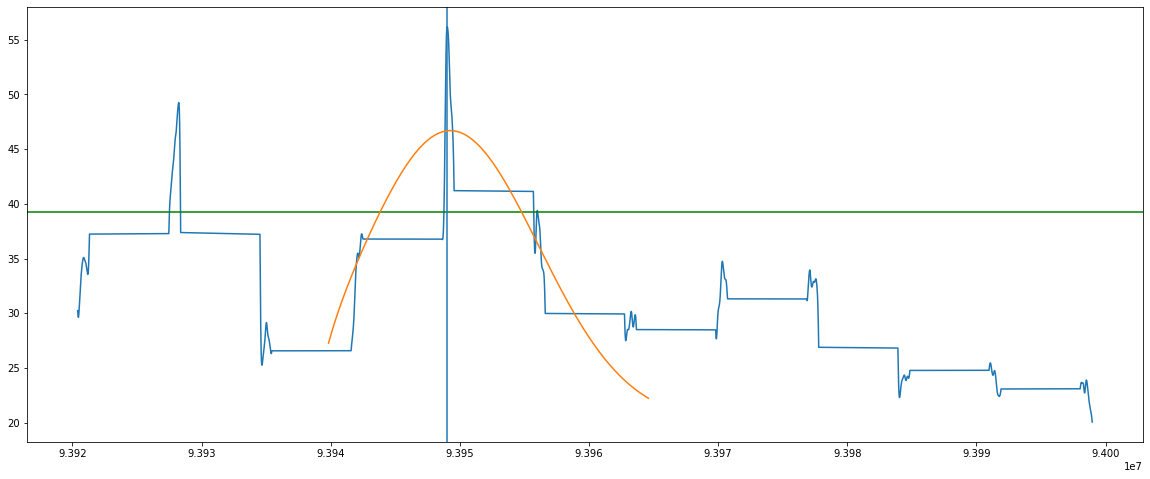

CURRENT NO. 84
[]
CURRENT NO. 85
[]
CURRENT NO. 86
[]
CURRENT NO. 87
[]
CURRENT NO. 88
[]
CURRENT NO. 89
[]
CURRENT NO. 90
[]
CURRENT NO. 91
[]
CURRENT NO. 92
[]
CURRENT NO. 93
[]
CURRENT NO. 94
[]
CURRENT NO. 95
[]
CURRENT NO. 96


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200106_v1_level2.lc


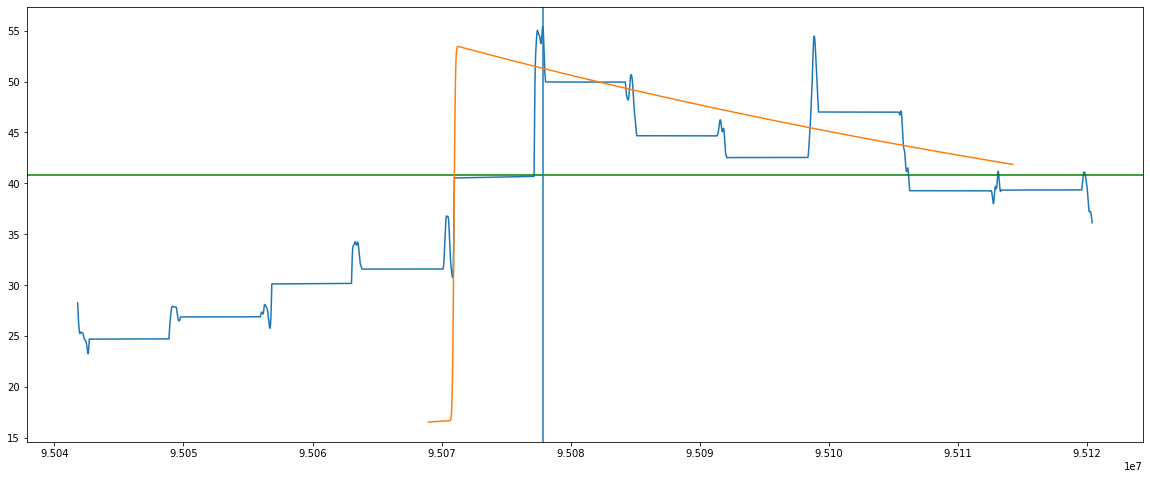

CURRENT NO. 97
[]
CURRENT NO. 98
[]
CURRENT NO. 99


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200109_v1_level2.lc


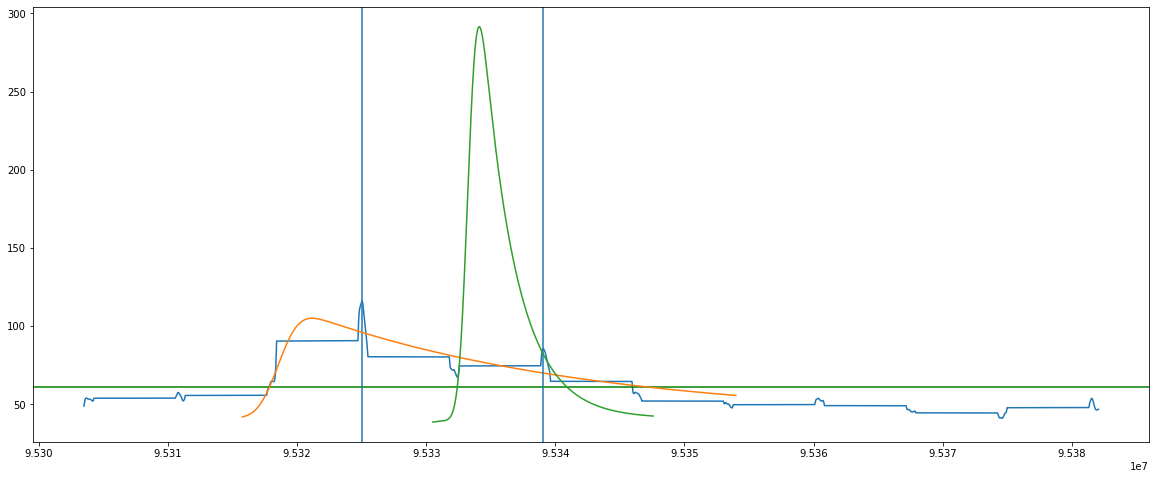

CURRENT NO. 100
[]
CURRENT NO. 101
[]
CURRENT NO. 102
[]
CURRENT NO. 103
[]
CURRENT NO. 104
[]
CURRENT NO. 105
[]
CURRENT NO. 106
[]
CURRENT NO. 107
[]
CURRENT NO. 108
[]
CURRENT NO. 109
[]
CURRENT NO. 110
[]
CURRENT NO. 111
[]
CURRENT NO. 112
[]
CURRENT NO. 113
[]
CURRENT NO. 114
[]
CURRENT NO. 115
[]
CURRENT NO. 116
[]
CURRENT NO. 117
[]
CURRENT NO. 118
[]
CURRENT NO. 119
[]
CURRENT NO. 120
[]
CURRENT NO. 121
[]
CURRENT NO. 122
[]
CURRENT NO. 123
[]
CURRENT NO. 124
[]
CURRENT NO. 125
[]
CURRENT NO. 126
[]
CURRENT NO. 127
[]
CURRENT NO. 128
[]
CURRENT NO. 129


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200311_v1_level2.lc


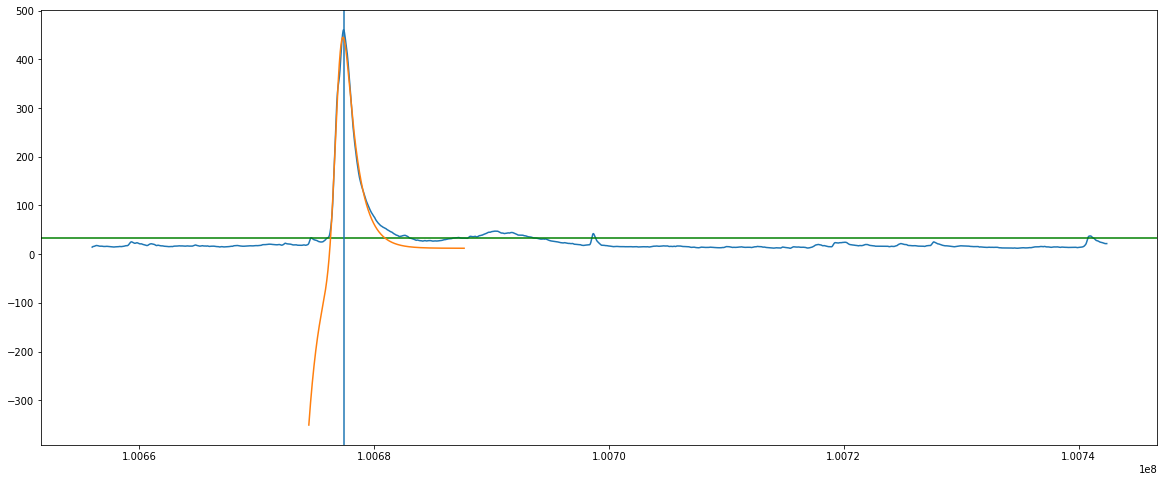

CURRENT NO. 130
[]
CURRENT NO. 131
[]
CURRENT NO. 132
[]
CURRENT NO. 133
[]
CURRENT NO. 134
[]
CURRENT NO. 135
[]
CURRENT NO. 136
[]
CURRENT NO. 137
[]
CURRENT NO. 138
[]
CURRENT NO. 139
[]
CURRENT NO. 140
[]
CURRENT NO. 141
[]
CURRENT NO. 142
[]
CURRENT NO. 143
[]
CURRENT NO. 144
[]
CURRENT NO. 145
[]
CURRENT NO. 146
[]
CURRENT NO. 147


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200329_v1_level2.lc


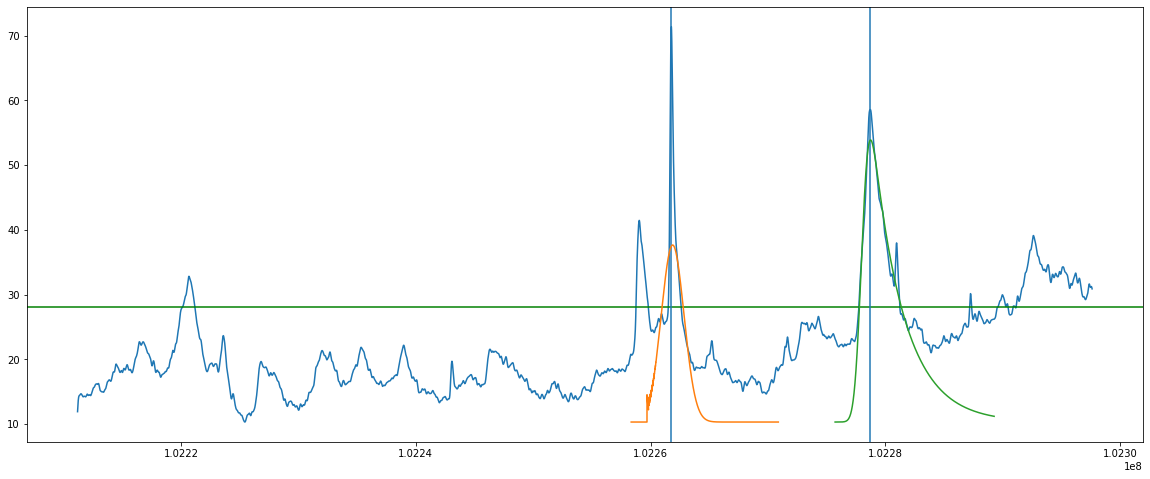

CURRENT NO. 148


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200330_v1_level2.lc


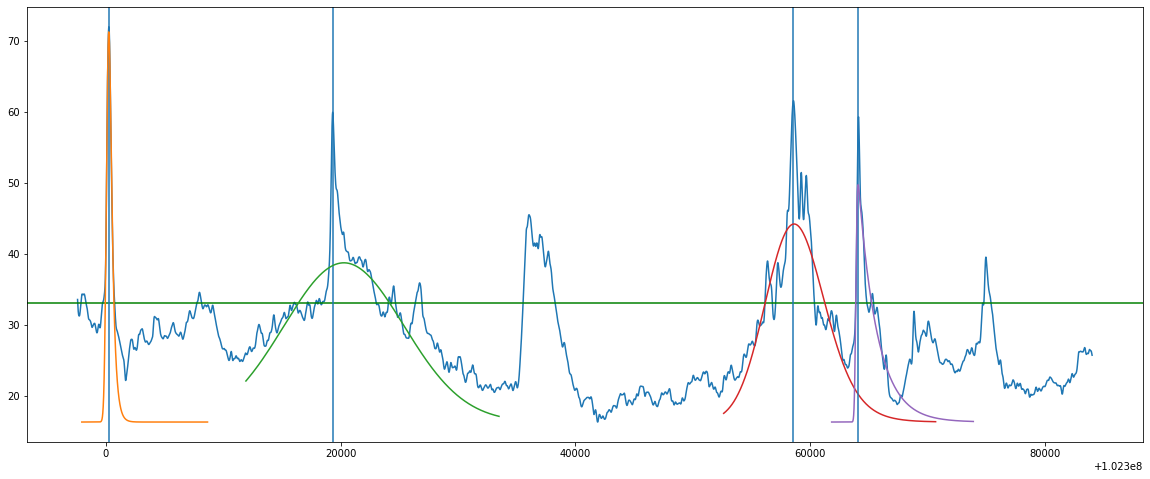

CURRENT NO. 149


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200331_v1_level2.lc


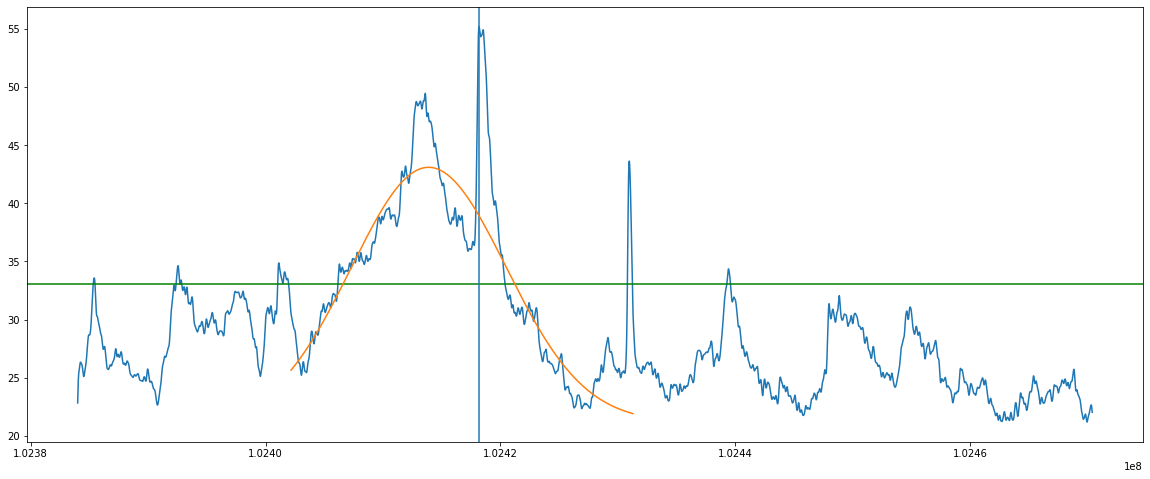

CURRENT NO. 150


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200401_v1_level2.lc


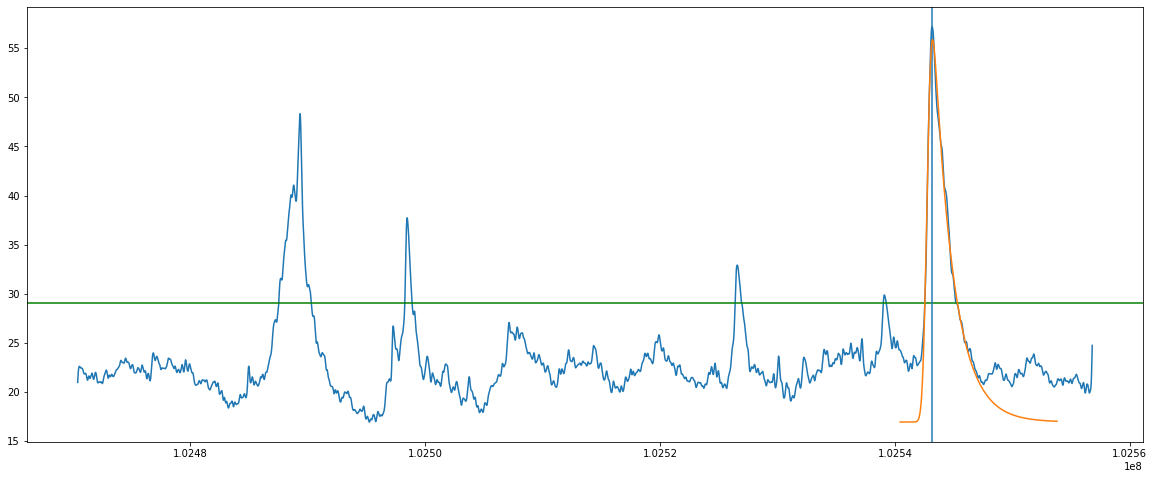

CURRENT NO. 151


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200402_v1_level2.lc


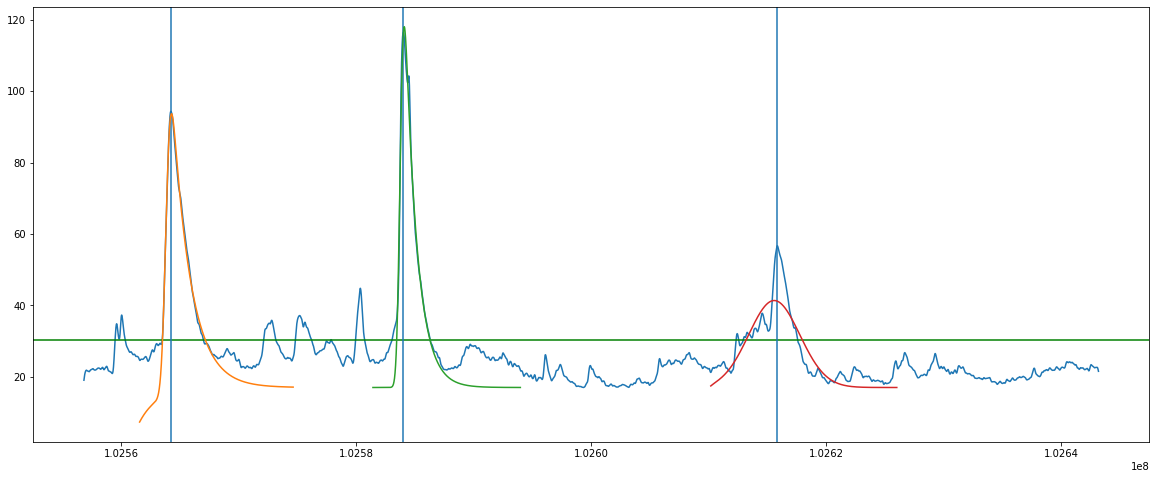

CURRENT NO. 152
[]
CURRENT NO. 153


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


[]
ch2_xsm_20200404_v1_level2.lc


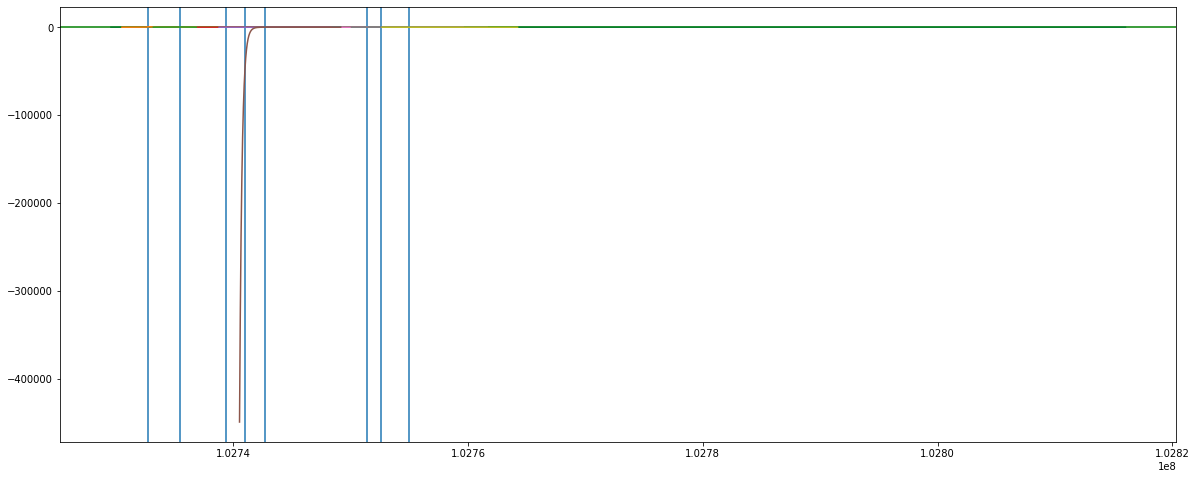

CURRENT NO. 154


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200405_v1_level2.lc


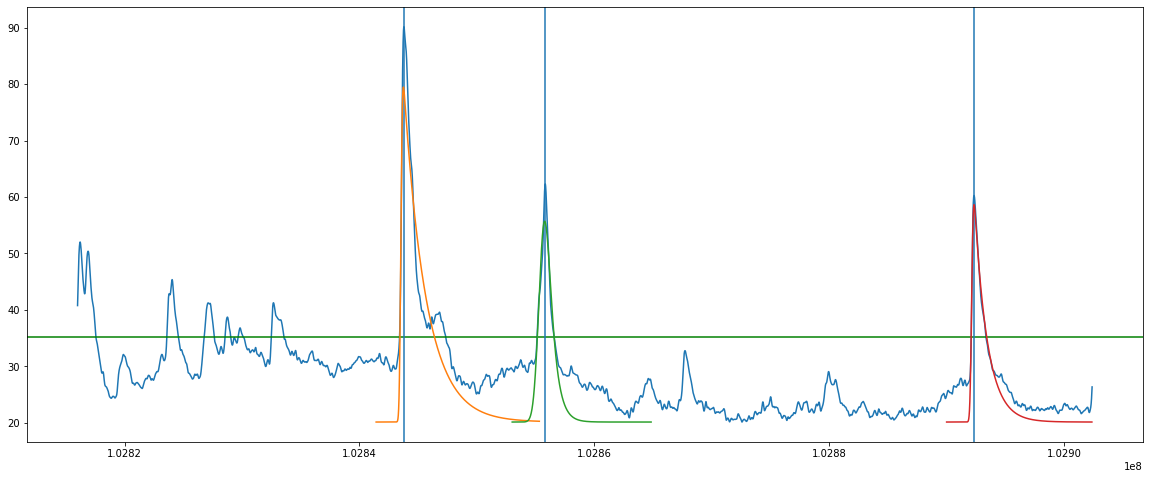

CURRENT NO. 155


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200406_v1_level2.lc


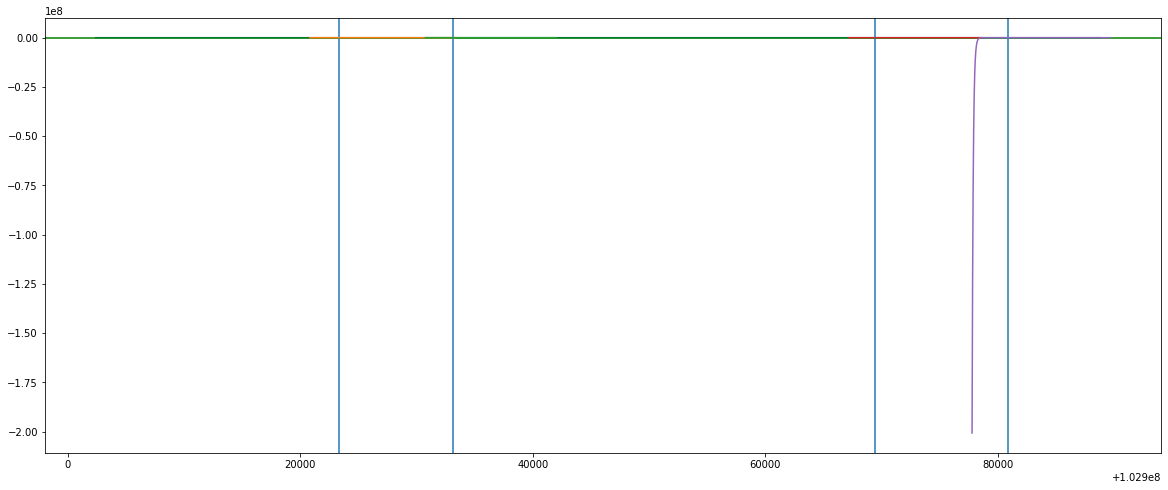

CURRENT NO. 156


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200407_v1_level2.lc


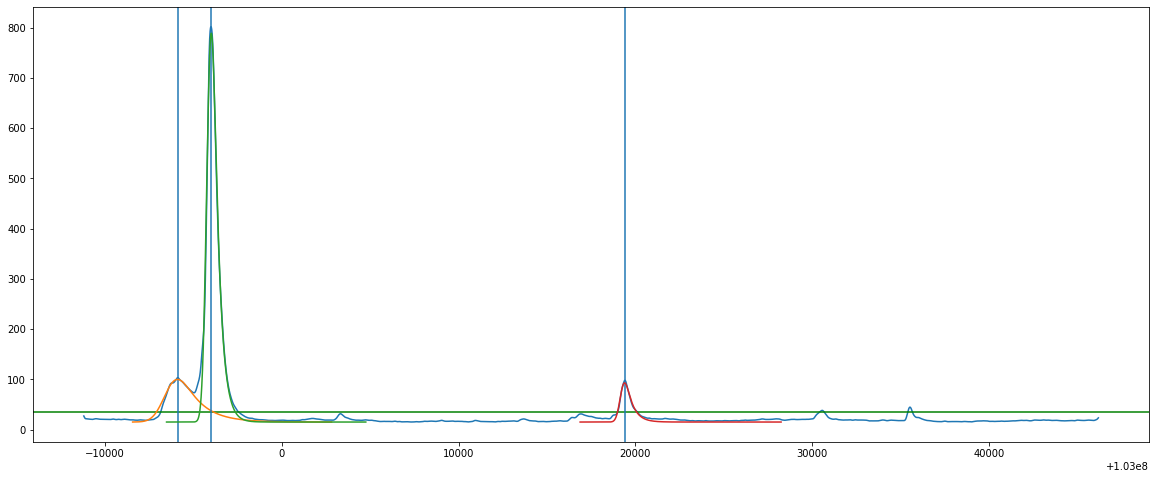

CURRENT NO. 157
[]
CURRENT NO. 158


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


[]
ch2_xsm_20200409_v1_level2.lc


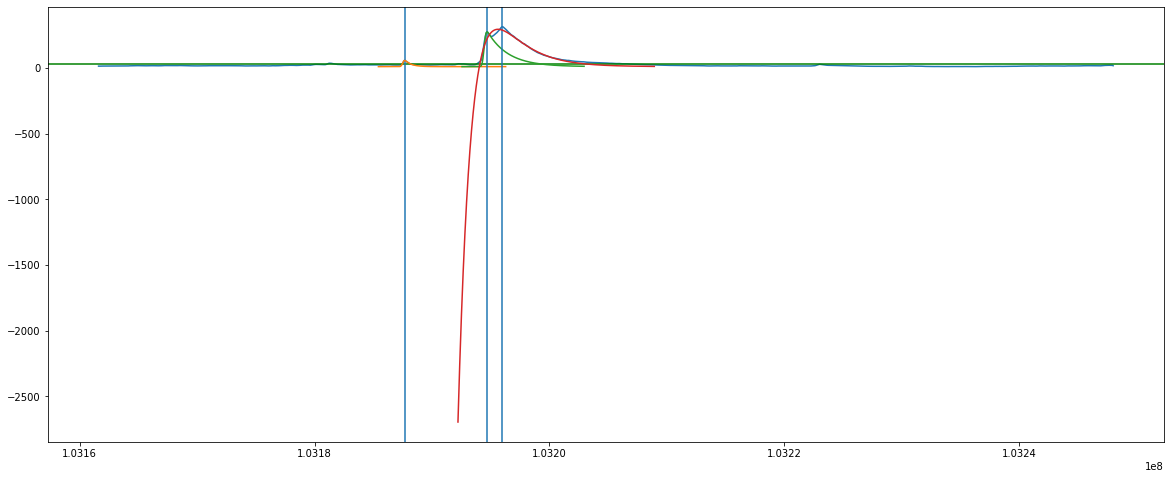

CURRENT NO. 159


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


[]
ch2_xsm_20200410_v1_level2.lc


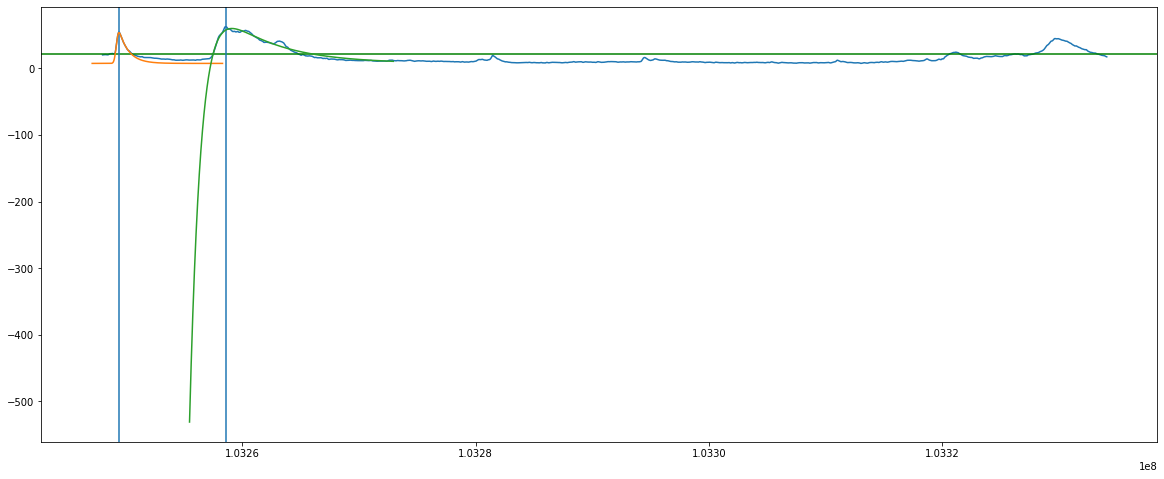

CURRENT NO. 160
[]
CURRENT NO. 161
[]
CURRENT NO. 162
[]
CURRENT NO. 163
[]
CURRENT NO. 164
[]
CURRENT NO. 165
[]
CURRENT NO. 166
[]
CURRENT NO. 167
[]
CURRENT NO. 168
[]
CURRENT NO. 169
[]
CURRENT NO. 170
[]
CURRENT NO. 171
[]
CURRENT NO. 172


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200423_v1_level2.lc


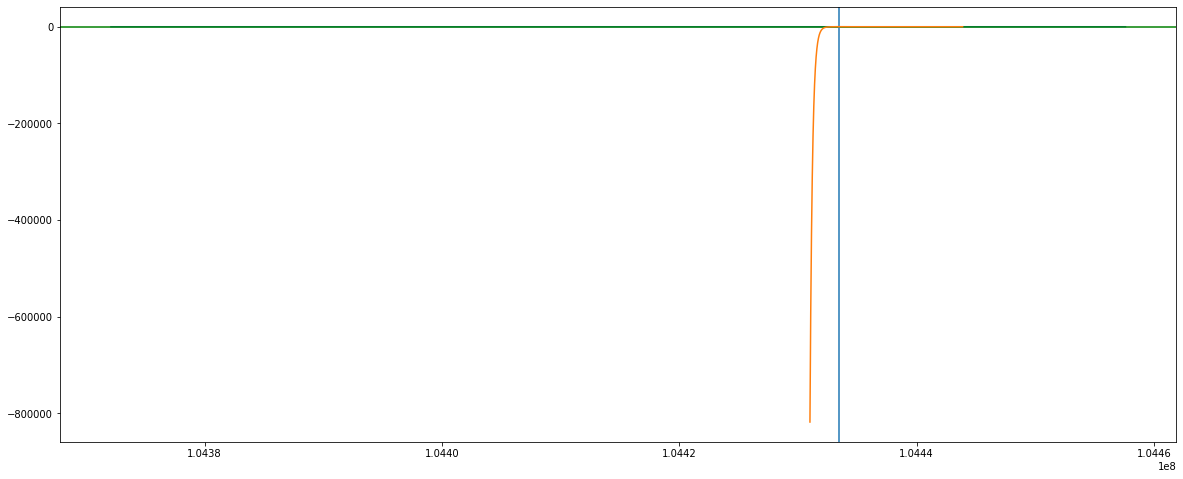

CURRENT NO. 173
[]
CURRENT NO. 174
[]
CURRENT NO. 175
[]
CURRENT NO. 176
[]
CURRENT NO. 177
[]
CURRENT NO. 178


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200429_v1_level2.lc


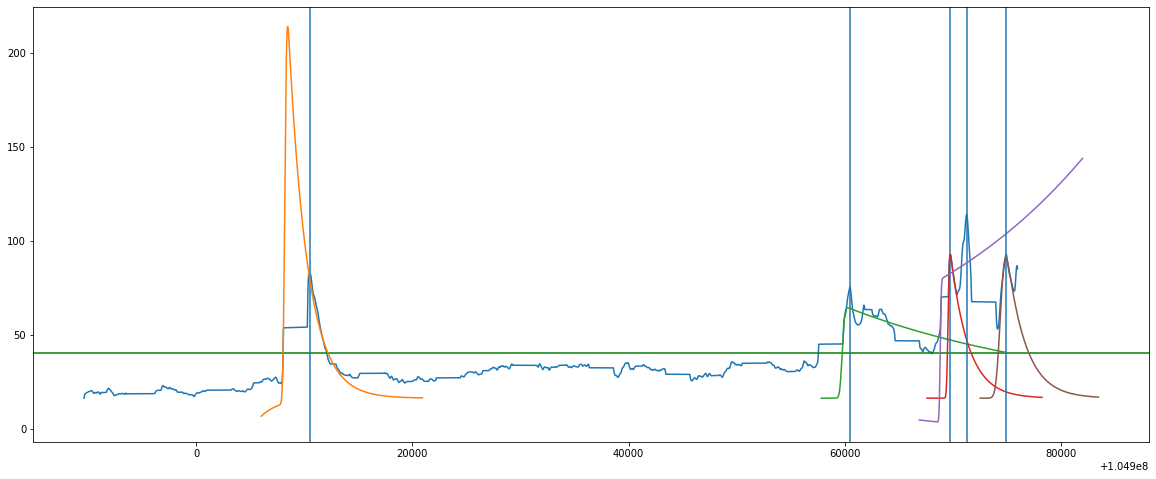

CURRENT NO. 179


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[1]
ch2_xsm_20200430_v1_level2.lc


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


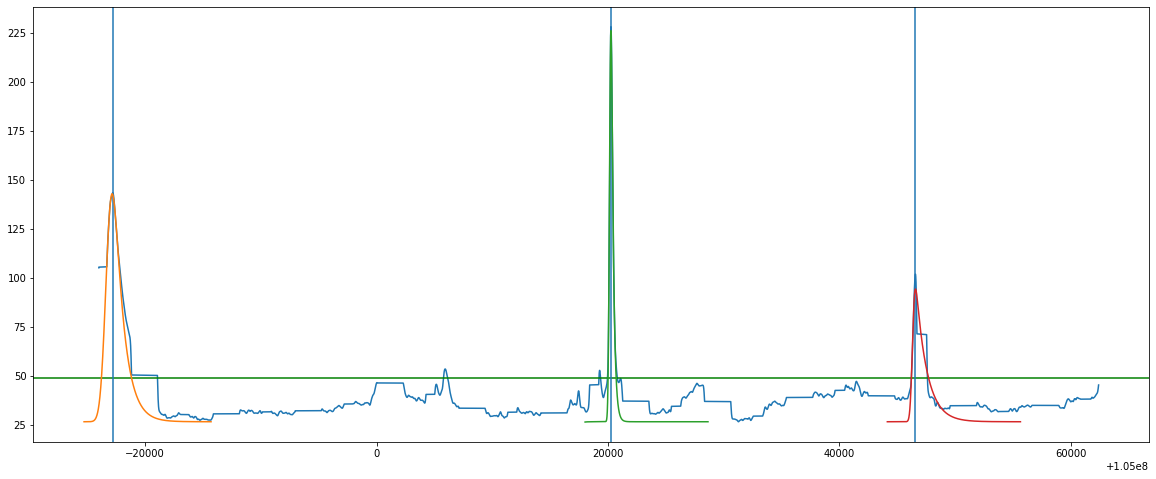

CURRENT NO. 180


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[2]
ch2_xsm_20200501_v1_level2.lc


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


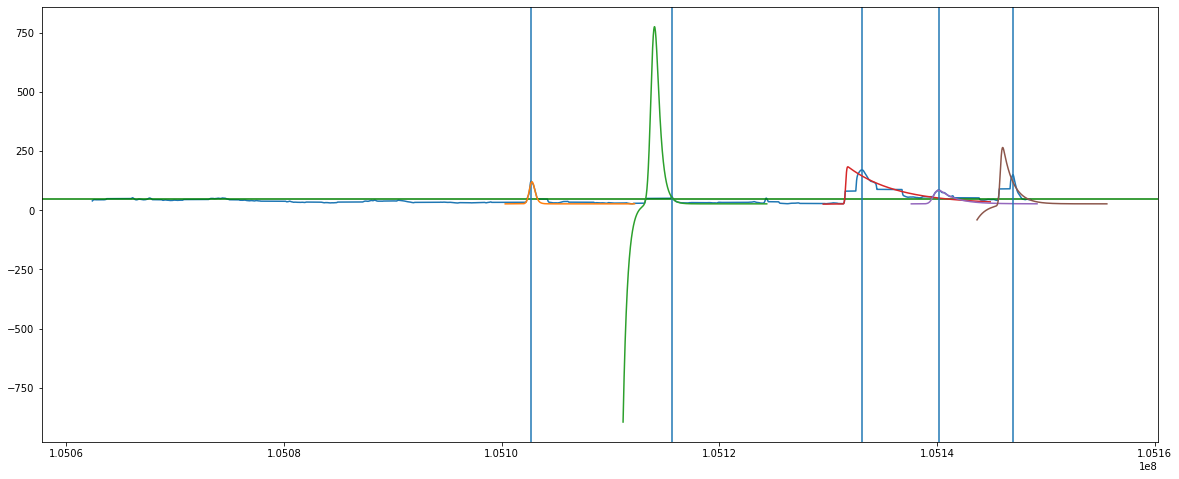

CURRENT NO. 181
[]
CURRENT NO. 182
[]
CURRENT NO. 183
[]
CURRENT NO. 184
[]
CURRENT NO. 185
[]
CURRENT NO. 186
[]
CURRENT NO. 187
[]
CURRENT NO. 188
[]
CURRENT NO. 189
[]
CURRENT NO. 190
[]
CURRENT NO. 191
[]
CURRENT NO. 192
[]
CURRENT NO. 193
[]
CURRENT NO. 194


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200515_v1_level2.lc


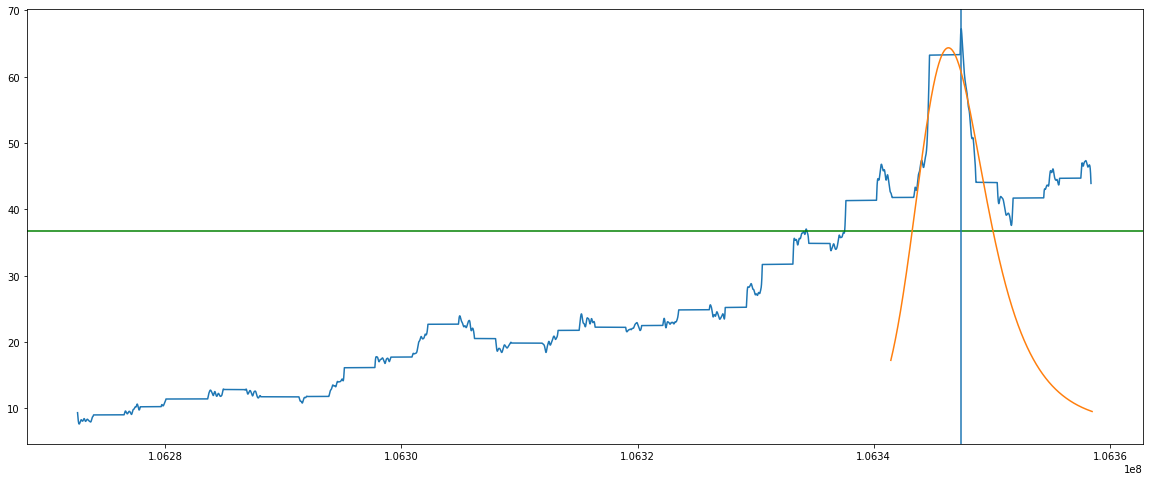

CURRENT NO. 195
[]
CURRENT NO. 196


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200517_v1_level2.lc


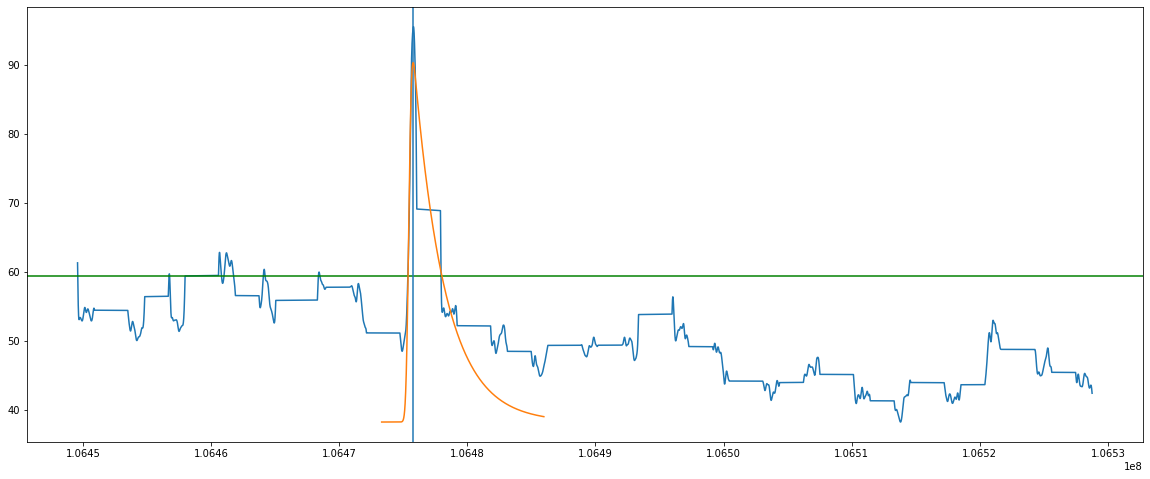

CURRENT NO. 197


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200518_v1_level2.lc


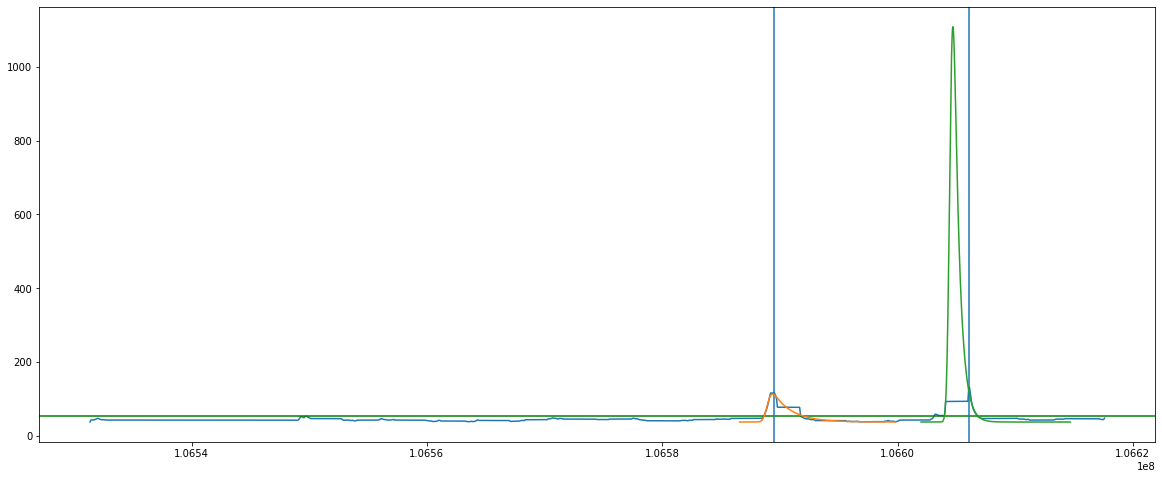

CURRENT NO. 198
[]
CURRENT NO. 199
[]
CURRENT NO. 200
[]
CURRENT NO. 201


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200608_v1_level2.lc


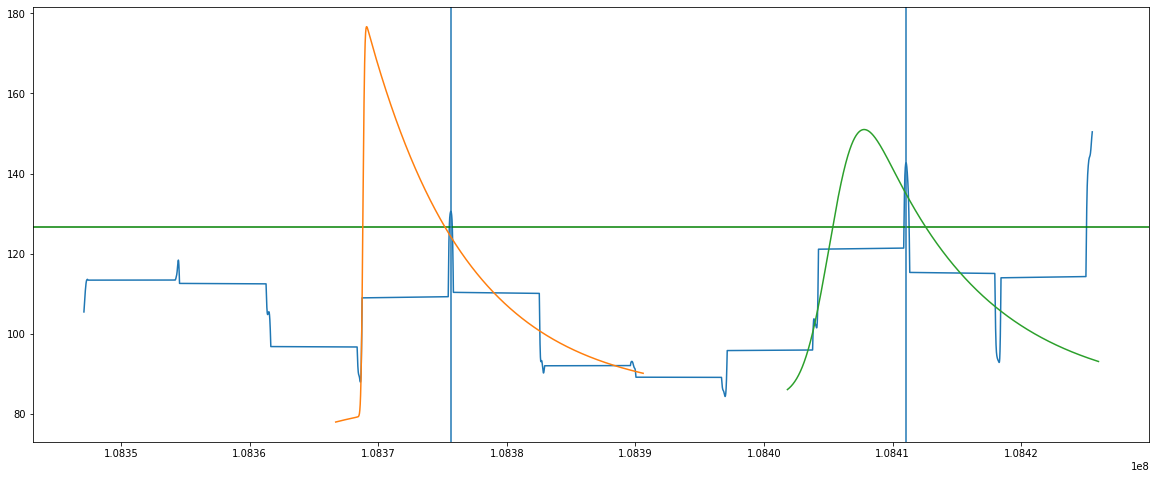

CURRENT NO. 202


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200609_v1_level2.lc


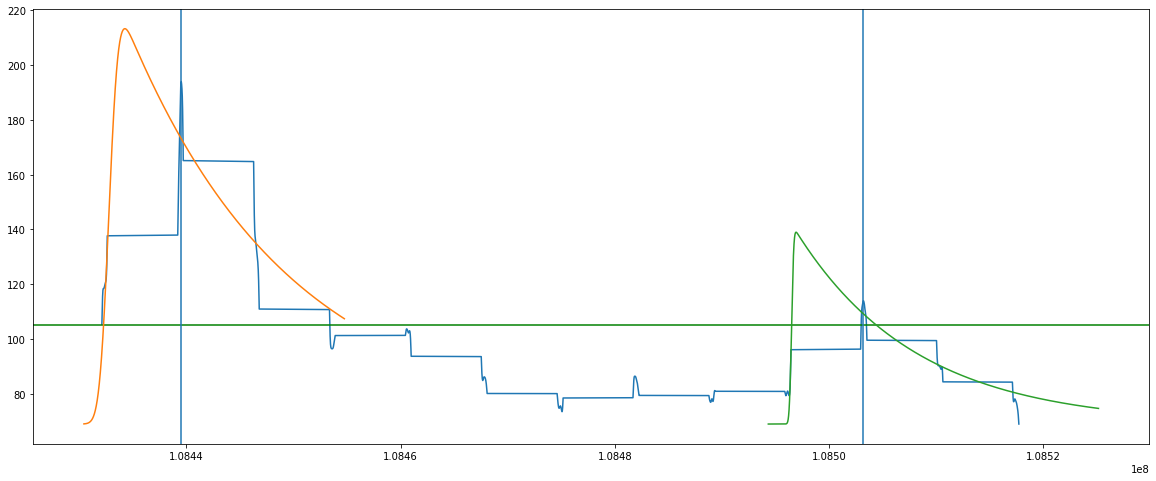

CURRENT NO. 203


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200610_v1_level2.lc


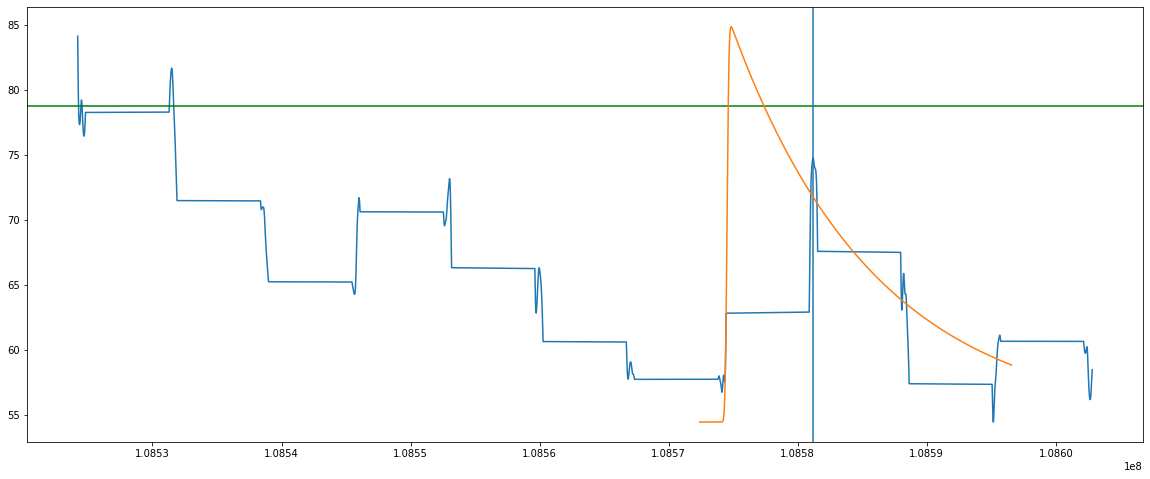

CURRENT NO. 204


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200611_v1_level2.lc


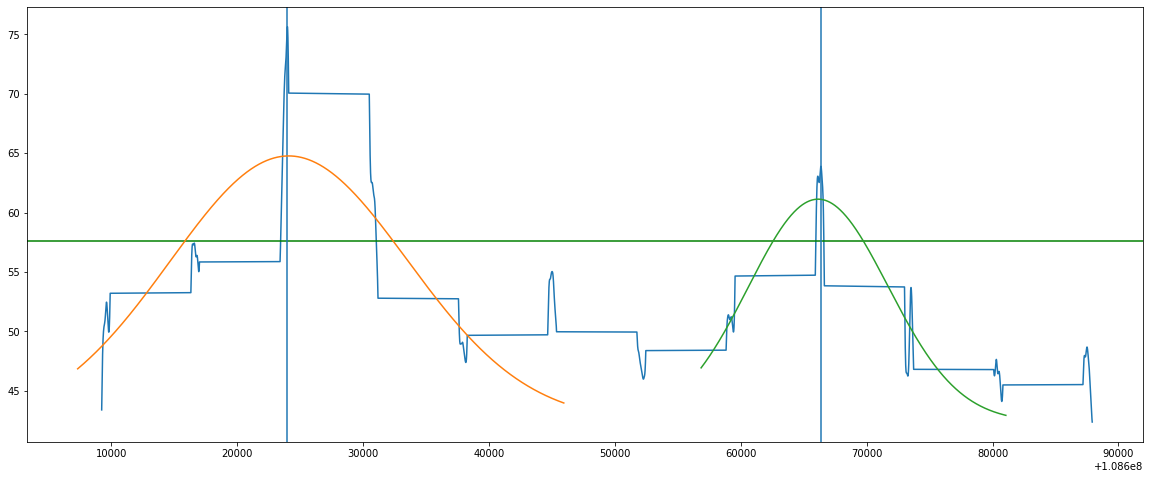

CURRENT NO. 205
[]
CURRENT NO. 206
[]
CURRENT NO. 207
[]
CURRENT NO. 208
[]
CURRENT NO. 209
[]
CURRENT NO. 210
[]
CURRENT NO. 211
[]
CURRENT NO. 212
[]
CURRENT NO. 213
[]
CURRENT NO. 214
[]
CURRENT NO. 215
[]
CURRENT NO. 216
[]
CURRENT NO. 217
[]
CURRENT NO. 218
[]
CURRENT NO. 219
[]
CURRENT NO. 220
[]
CURRENT NO. 221
[]
CURRENT NO. 222
[]
CURRENT NO. 223
[]
CURRENT NO. 224
[]
CURRENT NO. 225


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]
ch2_xsm_20200914_v1_level2.lc


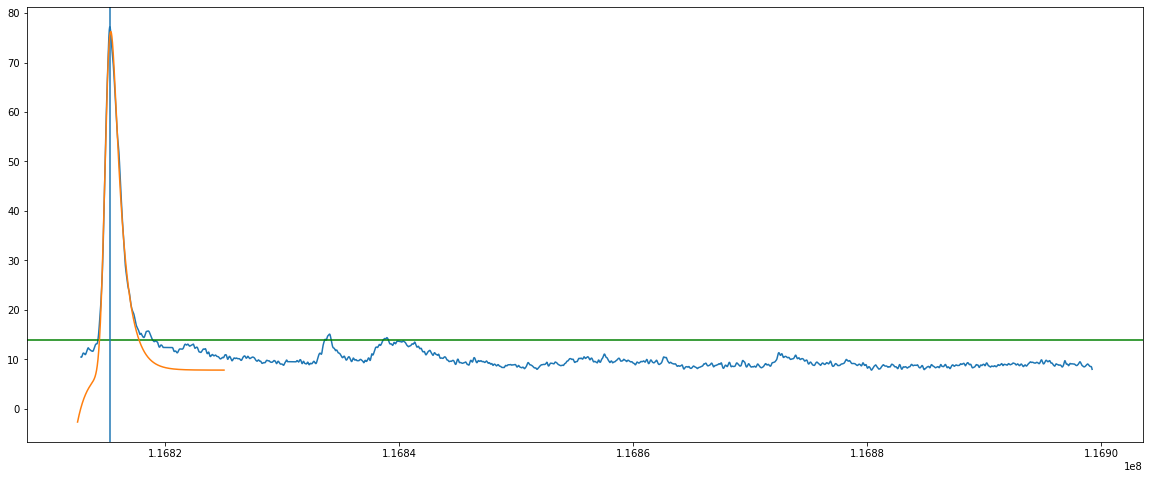

CURRENT NO. 226
[]
CURRENT NO. 227
[]
CURRENT NO. 228
[]
CURRENT NO. 229


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: ignored

In [160]:
x = np.zeros((0,7))
bg_dt = {}
for i in range(len(c)):
  print("CURRENT NO. "+ str(i))
  file1=Curve_Fitter(c[i])
  a = file1.params().to_numpy()
  if(a.shape[1]==3):
    continue
  
  print(c[i])
  file1.plotter(std=True,newplot = True)



  
  x = np.concatenate((x,a),axis = 0)
  